<a href="https://colab.research.google.com/github/HananeMaghlazi/P7_Scoring/blob/main/P7_Modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Modélisation** : 

- L'objectif dans cette partie du projet est de construire un modèle de scoring qui retournera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Rappel de la TARGET :
    * 1 :  client avec difficultés de paiement: il a eu un retard de paiement de plus de X jours sur au moins une des Y premières échéances du prêt de notre échantillon
    * 0 : Tous les autres cas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys, time
import fnmatch

# Pour les warnings
import warnings

warnings.filterwarnings("ignore")

import logging

logging.disable(logging.WARNING)  # disable WARNING, INFO and DEBUG logging everywhere
# Pour le ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from pandas import MultiIndex, Int16Dtype
from pandas import MultiIndex, Int64Index
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [3]:
# Modification des paramètres d'affichages des colonnes, lignes et largeurs des colonnes pour obtenir le plus d'information
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)
pd.set_option("float_format", lambda x: "%.4f" % x)


**Import du fichier** :

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/gdrive


In [5]:
link = 'https://drive.google.com/file/d/1kLKanGI2qrJPCWd5OUgSku9R6AukXocf/view?usp=share_link'
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('xclara.csv') 
 
data = pd.read_csv('xclara.csv')

In [6]:
data.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_

In [ ]:
data.shape

(307507, 790)

In [17]:
# check de la RAM
!cat /proc/meminfo 

MemTotal:       13297228 kB
MemFree:          220332 kB
MemAvailable:    8234764 kB
Buffers:           83140 kB
Cached:          4622476 kB
SwapCached:            0 kB
Active:           692668 kB
Inactive:       12014548 kB
Active(anon):       1380 kB
Inactive(anon):  4555528 kB
Active(file):     691288 kB
Inactive(file):  7459020 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1124 kB
Writeback:             0 kB
AnonPages:       8001616 kB
Mapped:           312640 kB
Shmem:              1292 kB
KReclaimable:     190048 kB
Slab:             229080 kB
SReclaimable:     190048 kB
SUnreclaim:        39032 kB
KernelStack:        5744 kB
PageTables:        42588 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648612 kB
Committed_AS:   10951168 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       50352 kB
VmallocChunk:          0 kB
Percpu:          

- Tester la modélisation sur un échantillon : 

In [7]:
# J'extrais un échantillon 20 % :
data_sample = data.sample(frac=0.2).round(3)
data_sample.shape

(61501, 790)

In [8]:
data_sample.set_index('SK_ID_CURR', inplace=True)


In [21]:
data_sample.TARGET.value_counts(normalize="True")

0.0000   0.9178
1.0000   0.0822
Name: TARGET, dtype: float64

In [14]:
data_sample.TARGET.value_counts()

0.0000    56446
1.0000     5055
Name: TARGET, dtype: int64

On voit bien que la classe majoritaire est la classe 0

 **Régression logistique en tant que baseline** : 

- Séparation du jeu de données en jeu d'entrainement et de test : 
- Séparation : 80% entrainement, 20% test

In [9]:
# Les features
X = data_sample.drop(["TARGET"], axis=1)
# La target
Y = data_sample[["TARGET"]]
# Division du dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, stratify=Y, random_state=42
)
print("shape of original dataset :", data_sample.shape)
print("shape of input - training set", X_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", X_test.shape)
print("shape of output - testing set", y_test.shape)

shape of original dataset : (61501, 789)
shape of input - training set (49200, 788)
shape of output - training set (49200, 1)
shape of input - testing set (12301, 788)
shape of output - testing set (12301, 1)


In [ ]:
print("Classe 1, sans SMOTE ", (y_train == 1).sum())
print("Classe 0, sans SMOTE:", (y_train == 0).sum())

Classe 1, sans SMOTE  TARGET    208
dtype: int64
Classe 0, sans SMOTE: TARGET    2252
dtype: int64


- Preprocessing avant modélisation:
- Utilisation du MinMaxScaler pour la standardisation des données

In [10]:
lr = Pipeline([('standarisation', MinMaxScaler()) , ( 'model',LogisticRegression(random_state=42))]) 
    
lr

Pipeline(steps=[('standarisation', MinMaxScaler()),
                ('model', LogisticRegression(random_state=42))])

In [11]:
# Fonction qui va entrainer le modèle,prédire et évaluer l'ensemble des modèles
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_true = y_test
    print(classification_report(y_true, y_pred))
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC : %0.4f" % roc_auc)

    fig = plt.figure(figsize=(20, 15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = [
        "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")

    plt.subplot(222)

    fper, tper, thresholds = roc_curve(y_true, y_pred_proba)
    plt.plot(fper, tper, color="red", label="AUC = %0.4f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="green", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic Curve")
    plt.legend()
    plt.show()

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     11290
         1.0       0.61      0.05      0.09      1011

    accuracy                           0.92     12301
   macro avg       0.77      0.52      0.52     12301
weighted avg       0.90      0.92      0.89     12301

AUC : 0.7565


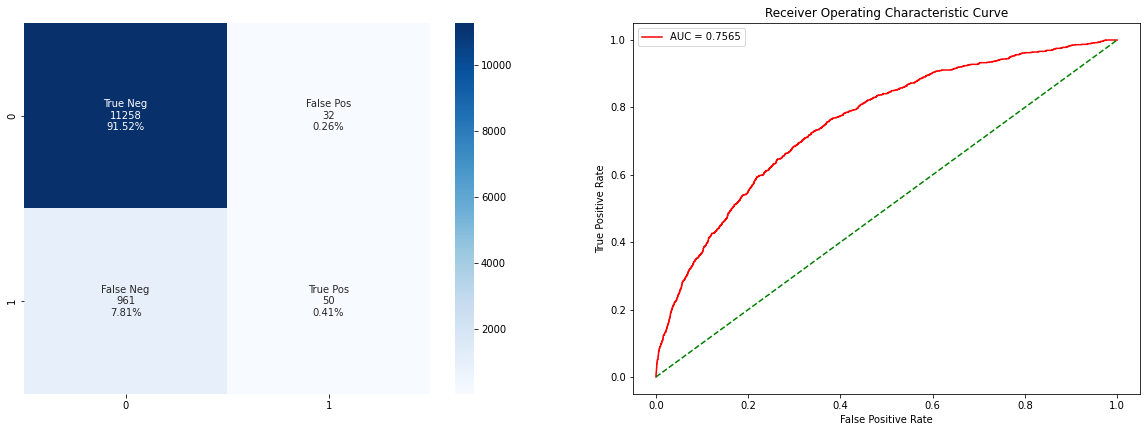

In [31]:
evaluation(lr)

- De bons résultats pour la target 0 mais pas pour la target 1
- Le désilquilibre entre les deux classes engendre de mauvaises performances sur la classe minoritaire
- Un problème avec la classification déséquilibrée est qu'il y a trop peu d'exemples de la classe minoritaire pour qu'un modèle apprenne efficacement la frontière de décision.
- Dans un premier temps tester différents modèles avec les memes classes
- Dans un deuxième temps avec classe équilibrés

XGBClassifier :

In [32]:
xgb = Pipeline([('standarisation', MinMaxScaler()) , ( 'model',XGBClassifier(random_state=42))]) 
    
xgb

Pipeline(steps=[('standarisation', MinMaxScaler()),
                ('model', XGBClassifier(random_state=42))])

GradientBoosting : 

In [33]:
grb = Pipeline([('standarisation', MinMaxScaler()) , ( 'model',GradientBoostingClassifier(random_state=42))]) 
    
grb

Pipeline(steps=[('standarisation', MinMaxScaler()),
                ('model', GradientBoostingClassifier(random_state=42))])

LGBMClassifier :

In [34]:
lgt = Pipeline([('standarisation', MinMaxScaler()) , ( 'model',LGBMClassifier(random_state=42))]) 
    
lgt

Pipeline(steps=[('standarisation', MinMaxScaler()),
                ('model', LGBMClassifier(random_state=42))])

- Tester différents algorithmes de machine learning avec parametres de base : 

In [35]:
model_pipeline = {
    
    "Gradientboosting": grb,
    "Xgbregressor": xgb,
    "LightGBM": lgt,
}

In [19]:
def metrics_models(model_pipeline):
    
    results = []
    cm_list = []
    for model_pipeline_name, model in model_pipeline.items():
        model.fit(X_train, y_train.values.ravel())
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        accuracy = accuracy_score(y_test, model.predict(X_test))
        precision = precision_score(y_test, model.predict(X_test))
        recall = recall_score(y_test, model.predict(X_test))
        f1 = f1_score(y_test, model.predict(X_test))
        cm_list.append(confusion_matrix(y_test, model.predict(X_test)))

        results.append([model_pipeline_name, auc, accuracy, precision, recall, f1])
        df = pd.DataFrame(
            results, columns=["Models", "Auc", "Accuracy", "Precision", "Recall", "F1"]
        )
    return df, cm_list

In [37]:
df_results, cm_list = metrics_models(model_pipeline)

In [38]:
df_results

,Models,Auc,Accuracy,Precision,Recall,F1
0,Gradientboosting,0.7694,0.9179,0.5077,0.0326,0.0613
1,Xgbregressor,0.7736,0.9181,0.5909,0.0129,0.0252
2,LightGBM,0.7714,0.9171,0.4554,0.0455,0.0827


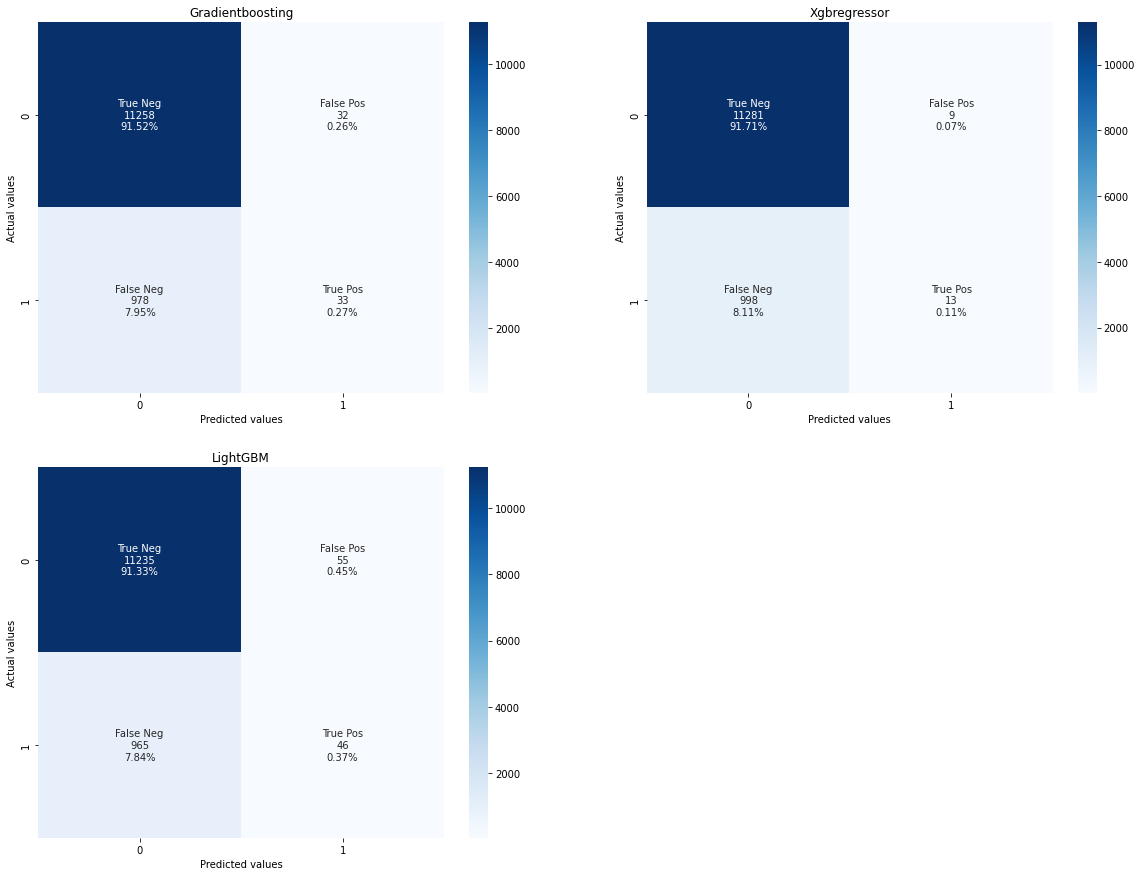

In [39]:
list_models = [
    
    
    "Gradientboosting",
    "Xgbregressor",
    "LightGBM",
]
# Visualisation des matrices de confusion
fig = plt.figure(figsize=(20, 15))

for i in range(len(cm_list)):
    model = list_models[i]
    cm = cm_list[i]
    sub = fig.add_subplot(2, 2, i + 1).set_title(model)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    cm_plot = sns.heatmap(cm, fmt="", annot=labels, cmap="Blues")
    cm_plot.set_xlabel("Predicted values")
    cm_plot.set_ylabel("Actual values")

- Amélioration des modèles:   Hyperparameters Tuning par des grid search: 

GRADIENTBOOSING : 

In [ ]:
classifier = GradientBoostingClassifier

param_gbt = {
    #"criterion": ["friedman_mse"],
    "n_estimators": [2, 4,10,50], # The number of boosting stages to perform
    "max_depth": [2,3,5, 6], # The maximum depth limits the number of nodes in the tree
    "learning_rate": [0.02,0.1,0.5],#Learning rate shrinks the contribution of each tree by learning_rate
    "min_samples_split" :[0.1, 0.5, 1. ] ,# The minimum number of samples required to split an internal node
    "min_samples_leaf" : [0.1, 0.2,0.5] ,# The minimum number of samples required to be at a leaf node
}

gbt_grid_cv = Pipeline(
    [
        ("preprocessor", MinMaxScaler()),
        (
            "grid_search_gbt",
            GridSearchCV(
                classifier(random_state=42),
                param_grid=param_gbt,
                cv=5,
                return_train_score=True,
                scoring="roc_auc",
                n_jobs=-1,
                refit=True
               
            ),
        ),
    ]
)

In [ ]:
gbt_grid_cv

Pipeline(steps=[('preprocessor', MinMaxScaler()),
                ('grid_search_gbt',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.02, 0.1, 0.5],
                                          'max_depth': [2, 3, 5, 6],
                                          'min_samples_leaf': [0.1, 0.2, 0.5],
                                          'min_samples_split': [0.1, 0.5, 1.0],
                                          'n_estimators': [2, 4, 10, 50]},
                              return_train_score=True, scoring='roc_auc'))])

XGBOOST : 

In [ ]:
# définition des Hyperparamètres
classifier = XGBClassifier
param_xgb = {
    "max_depth": [2, 4, 6],
    "learning_rate": [0.1, 0.01, 0.05],
    "n_estimators": [20],
    "min_child_weight": [1, 3, 6],
    "gamma": [0.0, 0.4],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "objective": ["binary:logistic"],
    "nthread": [4],
    # "scale_pos_weight" : [1],
    # "seed" : [2],
    "reg_alpha": [0.01, 0.05],
}

xgb_grid_cv = Pipeline(
    [
        ("preprocessor", MinMaxScaler()),
        (
            "grid_search_xgb",
            GridSearchCV(
                classifier(random_state=42),
                param_grid=param_xgb,
                cv=5,
                return_train_score=True,
                scoring="roc_auc",
                n_jobs=None,
                verbose=2,
            ),
        ),
    ]
)

In [ ]:
xgb_grid_cv

Pipeline(steps=[('preprocessor', MinMaxScaler()),
                ('grid_search_xgb',
                 GridSearchCV(cv=5, estimator=XGBClassifier(random_state=42),
                              param_grid={'colsample_bytree': [0.6, 0.8],
                                          'gamma': [0.0, 0.4],
                                          'learning_rate': [0.1, 0.01, 0.05],
                                          'max_depth': [2, 4, 6],
                                          'min_child_weight': [1, 3, 6],
                                          'n_estimators': [20], 'nthread': [4],
                                          'objective': ['binary:logistic'],
                                          'reg_alpha': [0.01, 0.05],
                                          'subsample': [0.6, 0.7, 0.8]},
                              return_train_score=True, scoring='roc_auc',
                              verbose=2))])

LIGHTGBM : 

In [ ]:
# définition des Hyperparamètres
classifier = LGBMClassifier
param_lgbm = {
     "nthread": [4],
     "n_estimators": [25,50],
    "learning_rate": [0.02,0.05],
     "colsample_bytree": [0.5, 0.9],
     "subsample": [0.3, 0.4, 0.8],
     "max_depth": [3, 4, 5, 6, 8],
     "reg_alpha": [0.02, 0.04],
     "reg_lambda": [0.02, 0.05, 0.07],
     "min_split_gain": [0.02, 0.05, 0.07],
     "min_child_weight": [30, 35, 40],
     "silent": [True],
}

lgbm_grid_cv = Pipeline(
    [
        ("preprocessor", MinMaxScaler()),
        (
            "grid_search_lgbm",
            GridSearchCV(
                classifier(random_state=42),
                param_grid=param_lgbm,
                cv=5,
                return_train_score=True,
                scoring="roc_auc",
                n_jobs=-1,
                verbose=False,
            ),
        ),
    ]
)

In [ ]:
lgbm_grid_cv

Pipeline(steps=[('preprocessor', MinMaxScaler()),
                ('grid_search_lgbm',
                 GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'colsample_bytree': [0.5, 0.9],
                                          'learning_rate': [0.02, 0.05],
                                          'max_depth': [3, 4, 5, 6, 8],
                                          'min_child_weight': [30, 35, 40],
                                          'min_split_gain': [0.02, 0.05, 0.07],
                                          'n_estimators': [25, 50],
                                          'nthread': [4],
                                          'reg_alpha': [0.02, 0.04],
                                          'reg_lambda': [0.02, 0.05, 0.07],
                                          'silent': [True],
                                          'subsample': [0.3, 0.4, 0.8]},
              

In [ ]:
data.shape

(307507, 790)

In [ ]:
model_pipeline = {
   
    "Gradientboosting": gbt_grid_cv,
    "Xgbregressor": xgb_grid_cv,
    'LGBMClassifier' : lgbm_grid_cv
}
df_results_grid,cm_list=metrics_models(model_pipeline)

In [ ]:
df_results_grid

,Models,Auc,Accuracy,Precision,Recall,F1
0,Gradientboosting,0.6135,0.9187,0.0000,0.0000,0.0000
1,Xgbregressor,0.6163,0.9187,0.0000,0.0000,0.0000
2,LGBMClassifier,0.6190,0.9187,0.0000,0.0000,0.0000


In [ ]:
df_results

,Models,Auc,Accuracy,Precision,Recall,F1
0,Gradientboosting,0.6216,0.9138,0.2000,0.0200,0.0364
1,Xgbregressor,0.5929,0.9203,1.0000,0.0200,0.0392
2,LightGBM,0.6117,0.9203,1.0000,0.0200,0.0392


Oversampling Data Using SMOTE:
- SMOTE with Imbalance Data using imblearn module
L'application correcte du suréchantillonnage lors de la validation croisée Ceci consiste à appliquer la méthode à l'ensemble de données d'apprentissage uniquement, puis à évaluer le modèle sur l'ensemble de test stratifié mais non transformé.

Ceci peut être réalisé en définissant un Pipeline qui transforme d'abord l'ensemble de données d'apprentissage avec SMOTE puis adapte le modèle.

In [13]:
# transform the dataset
smt = SMOTE(random_state=42)
smt

SMOTE(random_state=42)

In [41]:
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
print("Classe 1, avec SMOTE ", (y_train_sm == 1).sum())
print("Classe 0, avec SMOTE:", (y_train_sm == 0).sum())

Classe 1, avec SMOTE  TARGET    45156
dtype: int64
Classe 0, avec SMOTE: TARGET    45156
dtype: int64


In [42]:
# Test avec un seul modèle (Régression logistique)
lr.fit(X_train_sm, y_train_sm)

accuracy = accuracy_score(y_test, lr.predict(X_test))
precision = precision_score(y_test, lr.predict(X_test))
auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
print("AUC", auc, "\n" "Accuracy", accuracy, "\n" "Precesion", precision)

AUC 0.7537672844065152 
Accuracy 0.6993740346313307 
Precesion 0.16933300516859465


Tester les modèles sans optimisation de paramètres avec smote en pipeline : 

GradientBoosting : 

In [43]:
grb = GradientBoostingClassifier(random_state=42)
grb_smote = Pipeline(
    [("smt", smt), ("standardisation", MinMaxScaler()), ("model", grb)]
)
grb_smote

Pipeline(steps=[('smt', SMOTE(random_state=42)),
                ('standardisation', MinMaxScaler()),
                ('model', GradientBoostingClassifier(random_state=42))])

XGBOOST : 

In [44]:
xgb = XGBClassifier(random_state=42)
xgb_smote = Pipeline(
    [("smt", smt), ("standardisation", MinMaxScaler()), ("model", xgb)]
)
xgb_smote

Pipeline(steps=[('smt', SMOTE(random_state=42)),
                ('standardisation', MinMaxScaler()),
                ('model', XGBClassifier(random_state=42))])

LIGHTGBM : 

In [45]:
lgt = LGBMClassifier(random_state=42)
lgt_smote = Pipeline(
    [("smt", smt), ("standardisation", MinMaxScaler()), ("model", lgt)]
)
lgt_smote

Pipeline(steps=[('smt', SMOTE(random_state=42)),
                ('standardisation', MinMaxScaler()),
                ('model', LGBMClassifier(random_state=42))])

Tester les modèles avec smote en pipeline :

In [46]:
model_pipeline = {
   
    "Gradientboosting": grb_smote,
    "Xgbregressor": xgb_smote,
    'LGBMClassifier' : lgt_smote
}
df_results_smote, cm_list = metrics_models(model_pipeline)

In [48]:
df_results_smote

,Models,Auc,Accuracy,Precision,Recall,F1
0,Gradientboosting,0.7446,0.9178,0.5000,0.0148,0.0288
1,Xgbregressor,0.7454,0.9181,0.6667,0.0059,0.0118
2,LGBMClassifier,0.7679,0.9171,0.4444,0.0356,0.0659


In [47]:
# Je compare avec données sans smote
df_results

,Models,Auc,Accuracy,Precision,Recall,F1
0,Gradientboosting,0.7694,0.9179,0.5077,0.0326,0.0613
1,Xgbregressor,0.7736,0.9181,0.5909,0.0129,0.0252
2,LightGBM,0.7714,0.9171,0.4554,0.0455,0.0827


Pas de grandes améliorations : 

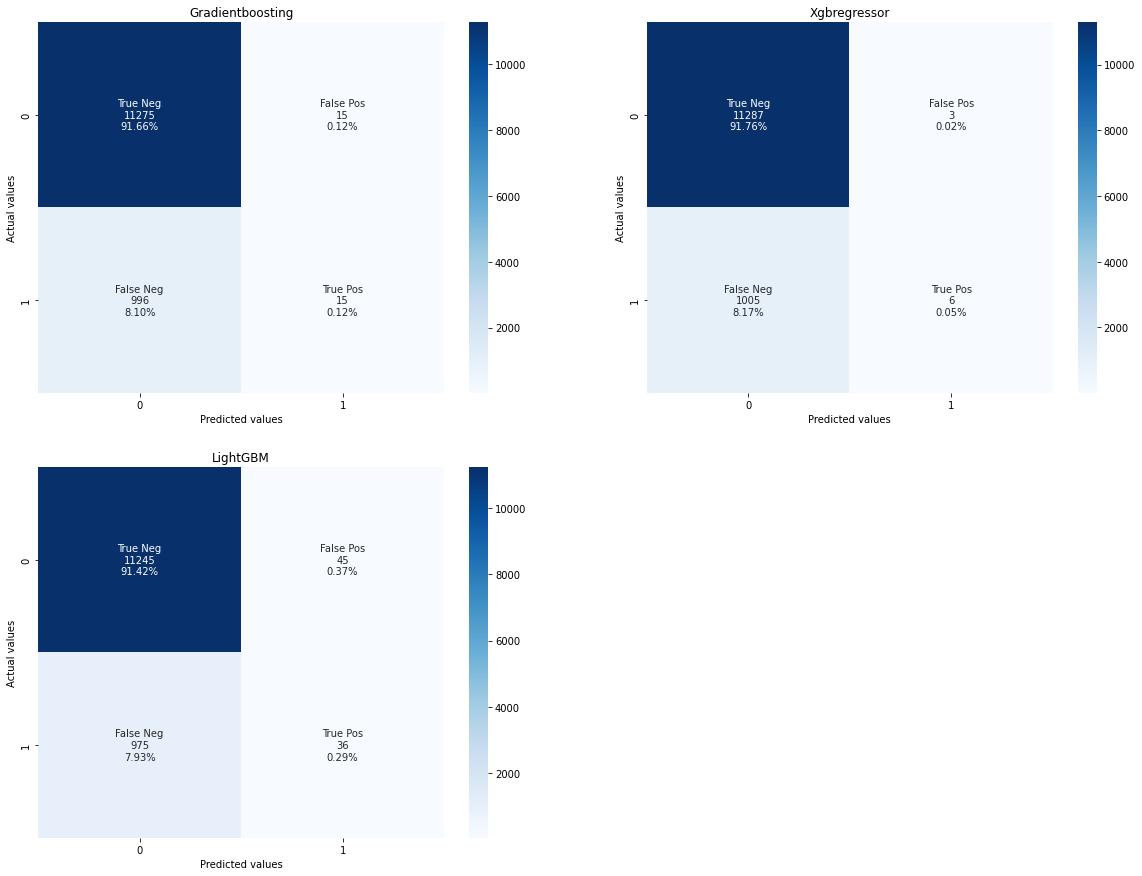

In [49]:
list_models = ["Gradientboosting","Xgbregressor","LightGBM"]
# Visualisation des matrices de confusion
fig = plt.figure(figsize=(20, 15))

for i in range(len(cm_list)):
    model = list_models[i]
    cm = cm_list[i]
    sub = fig.add_subplot(2, 2, i + 1).set_title(model)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    cm_plot = sns.heatmap(cm, fmt="", annot=labels, cmap="Blues")
    cm_plot.set_xlabel("Predicted values")
    cm_plot.set_ylabel("Actual values")

_ Optimation par des gridsearchs avec smote 
- Redéfinition des pipelines

In [14]:
classifier = GradientBoostingClassifier

param_gbt = {
    #"criterion": ["friedman_mse"],
    "n_estimators": [2, 4,10,50], # The number of boosting stages to perform
    "max_depth": [2,3,5, 6], # The maximum depth limits the number of nodes in the tree
    "learning_rate": [0.02,0.1,0.5],#Learning rate shrinks the contribution of each tree by learning_rate
    "min_samples_split" :[0.1, 0.5, 1. ] ,# The minimum number of samples required to split an internal node
    "min_samples_leaf" : [0.1, 0.2,0.5] ,# The minimum number of samples required to be at a leaf node
}

gbt_grid_cv_smote = Pipeline(
    [
        ("smt", smt),
        ("preprocessor", MinMaxScaler()),
        (
            "grid_search_gbt",
            GridSearchCV(
                classifier(random_state=42),
                param_grid=param_gbt,
                cv=5,
                return_train_score=True,
                scoring="roc_auc",
                n_jobs=-1,#using all processors
                refit=True # Refit an estimator using the best found parameters on the whole dataset.
               
            ),
        ),
    ]
)
gbt_grid_cv_smote

Pipeline(steps=[('smt', SMOTE(random_state=42)),
                ('preprocessor', MinMaxScaler()),
                ('grid_search_gbt',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.02, 0.1, 0.5],
                                          'max_depth': [2, 3, 5, 6],
                                          'min_samples_leaf': [0.1, 0.2, 0.5],
                                          'min_samples_split': [0.1, 0.5, 1.0],
                                          'n_estimators': [2, 4, 10, 50]},
                              return_train_score=True, scoring='roc_auc'))])

In [16]:
# définition des Hyperparamètres
classifier = XGBClassifier
param_xgb = {
    "max_depth": [2, 4, 6],
    "learning_rate": [0.1, 0.01, 0.05],
    "n_estimators": [20],
    "min_child_weight": [1, 3, 6],
    "gamma": [0.0, 0.4],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "objective": ["binary:logistic"],
    "nthread": [4],
    # "scale_pos_weight" : [1],
    # "seed" : [2],
    "reg_alpha": [0.01, 0.05],
}

xgb_grid_cv_smote = Pipeline(
    [
         ("smt", smt),
        ("preprocessor", MinMaxScaler()),
        (
            "grid_search_xgb",
            GridSearchCV(
                classifier(random_state=42),
                param_grid=param_xgb,
                cv=5,
                return_train_score=True,
                scoring="roc_auc",
                n_jobs=-1, #using all processors
                refit=True, # Refit an estimator using the best found parameters on the whole dataset.
                verbose=2, # Afficher l'exécution
            ),
        ),
    ]
)
xgb_grid_cv_smote

Pipeline(steps=[('smt', SMOTE(random_state=42)),
                ('preprocessor', MinMaxScaler()),
                ('grid_search_xgb',
                 GridSearchCV(cv=5, estimator=XGBClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'colsample_bytree': [0.6, 0.8],
                                          'gamma': [0.0, 0.4],
                                          'learning_rate': [0.1, 0.01, 0.05],
                                          'max_depth': [2, 4, 6],
                                          'min_child_weight': [1, 3, 6],
                                          'n_estimators': [20], 'nthread': [4],
                                          'objective': ['binary:logistic'],
                                          'reg_alpha': [0.01, 0.05],
                                          'subsample': [0.6, 0.7, 0.8]},
                              return_train_score=True, scoring='roc_auc',
                    

In [17]:
# définition des Hyperparamètres
classifier = LGBMClassifier
param_lgbm = {
     "nthread": [4],
     "n_estimators": [25,50],
    "learning_rate": [0.02,0.05],
     "colsample_bytree": [0.5, 0.9],
     "subsample": [0.3, 0.4, 0.8],
     "max_depth": [2, 6, 8],
     "reg_alpha": [0.02, 0.04],
     "reg_lambda": [0.02, 0.05],
     "min_split_gain": [0.02, 0.05],
     "min_child_weight": [30, 40],
     
}

lgbm_grid_cv_smote = Pipeline(
    [
        ("smt", smt),
        ("preprocessor", MinMaxScaler()),
        (
            "grid_search_lgbm",
            GridSearchCV(
                classifier(random_state=42),
                param_grid=param_lgbm,
                cv=5,
                return_train_score=True,
                scoring="roc_auc",
                n_jobs=-1, #using all processors
                refit=True, #Refit an estimator using the best found parameters on the whole dataset.
                verbose=False, 
            ),
        ),
    ]
)
lgbm_grid_cv_smote

Pipeline(steps=[('smt', SMOTE(random_state=42)),
                ('preprocessor', MinMaxScaler()),
                ('grid_search_lgbm',
                 GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'colsample_bytree': [0.5, 0.9],
                                          'learning_rate': [0.02, 0.05],
                                          'max_depth': [2, 6, 8],
                                          'min_child_weight': [30, 40],
                                          'min_split_gain': [0.02, 0.05],
                                          'n_estimators': [25, 50],
                                          'nthread': [4],
                                          'reg_alpha': [0.02, 0.04],
                                          'reg_lambda': [0.02, 0.05],
                                          'subsample': [0.3, 0.4, 0.8]},
                              return_train_scor

In [ ]:
model_pipeline_smote = {
    
   
    "Gradientboosting": gbt_grid_cv_smote,
    "Xgbregressor": xgb_grid_cv_smote,
    "LGBMClassifier" : lgbm_grid_cv_smote
}
df_results_grid_smote, cm_list = metrics_models(model_pipeline_smote)

In [ ]:
df_results_grid_smote

,Models,Auc,Accuracy,Precision,Recall,F1
0,Gradientboosting,0.6452,0.9106,0.2000,0.0652,0.0984
1,Xgbregressor,0.5975,0.9236,0.3333,0.0217,0.0408
2,LGBMClassifier,0.6450,0.9236,0.3333,0.0217,0.0408


**Explication métier** : 

cas positif 1 : Difficulté de paiement
cas négatif 0 : Pas de difficulté de paiement

TP: Le client a des difficultés de paiement et le modèle prédit qu'il a des diffcultés

TN: Le client n'a pas de difficultés de paiement et le modèle prédit qu'il n'a pas de difficultés de paiement

FP: Le client n'a pas de difficultés de paiement et le modèle prédit a des difficultés de paiement (erreur de type 1)

FN: Le client a des difficultés de paiement et le modèle prédit n'a pas de difficultés de paiement(erreur de type 2)

**Fonction métier personnalisée** : 

fonction gain avec(pondération)  pour chacun d'eux, mais en indiquant le coût le plus élevé du FN :

gain = TP * poids +TN * poids+ FP * poids+ FN * poids

TP: 0 (la banque ne gagne pas et ne perd pas : 0 cout et 0 gain)

TN: + 5 (un gain pour la banque)

FP: - 5 (perte potentiel client)

FN: - 10 (grande perte pour la banque)

In [ ]:
def function_cost(ytest, y_pred):
    tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
    cost = (tn*5) +(fp* -5)+(fn* -10)+(tp*0)
  
    return cost

In [ ]:
from sklearn.metrics import make_scorer
cost_score = make_scorer(function_cost, greater_is_better = True)
# Puis utiliser cost_score dans scoring de la grid search